In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import time
import os

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,accuracy_score

from sklearn.model_selection import GridSearchCV,PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.metrics import log_loss
from sklearn import metrics

import itertools
import matplotlib.pyplot as plt

##可以尝试xgboost,如果你装了这个包
##Terminal里运行:conda install -c conda-forge xgboost 

#import xgboost as xgb
#from xgboost import XGBClassifier


%matplotlib inline

C:\Applications\Programming\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
nowpath=os.path.abspath('.')
#最大显示列数
pd.options.display.max_columns=999
pd.options.display.max_rows=999

### Numpy

In [7]:
ac = np.random.rand(3,3)*10

In [8]:
ac

array([[3.96252531, 6.81807344, 7.18644533],
       [0.30131609, 9.20880038, 3.36334848],
       [9.59795637, 7.77351078, 4.96801874]])

### 数据清理，特征工程

In [3]:
col=['I','dont','know','what','is','this','data','set','wow','wo','ho','y']

In [4]:
df=pd.read_csv('cell2cell_data.csv',sep=',',engine='python',names=col)

In [5]:
df.head()

,I,dont,know,what,is,this,data,set,wow,wo,ho,y
0,48.82,10.00,3.0,26,780,0,0,0,0,1,4,1
1,83.53,20.00,1.0,31,745,1,0,0,0,0,4,1
2,29.99,0.00,0.0,52,1441,0,0,0,1,1,3,1
3,51.42,0.00,0.0,36,59,1,0,0,0,0,4,1
4,37.75,2.67,0.0,25,572,0,0,0,1,1,3,1


In [6]:
#制作dummy
enc_one, enc_label = OneHotEncoder(), LabelEncoder()
df['this'] = enc_label.fit_transform(df['this'])
labels=['this_'+str(x) for x in enc_label.classes_]
this = pd.DataFrame(enc_one.fit_transform(df[['this']]).todense(), columns = labels)
df = pd.concat([df,this], axis = 1)
df.__delitem__('this')

In [7]:
#Normalization，多用于SVM预处理
df['what']=preprocessing.scale(df['what'])

E:\Programming\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [8]:
#丢弃列
df=df.drop(['this_0','this_1'],axis=1)

In [9]:
#建立hierarchical数据，hier_out是想得到的hierarchical，hier_in是分割点。
hier_out=[1,2,4,8]
hier_in=[-10,10,50,100,2000]
df['is']=pd.Series(pd.cut(df['is'],hier_in,right=True,labels=hier_out))

In [10]:
#填充Nan为平均值/指定值
df['ho']=df['ho'].fillna(df['ho'].mean())

In [11]:
#丢弃Nan所在行，只考虑某一列的nan
df=df.dropna(subset=['wow'],axis=0)

In [ ]:
#如果数据中的nan是'nan'，文本型或np.nan，可以考虑用下面的赋值法，将其赋值为None，之后drop

In [42]:
#可用于制作hierarchical feature,I在40到60之间的被赋值100
df.loc[df[df.loc[:,'I']>40][df.loc[:,'I']<60].index,'I']=100
#对于what中每个大于50的x，让他变成自己的2倍。这个apply命令也可用于转换数据格式，如x:str(x) if x!='nan'
df['what']=df['what'].apply(lambda x:x*2 if x>50 else x)

E:\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [ ]:
#合并数据集，前提是key_left和key_right有对应关系
df_merged=pd.merge(df,other_df,how='inner',left_on='key_left',right_on='key_right')
#连接数据集，前提是column名字一样
df_concated=pd.concat([df,other_df])

### 训练模型，预测

In [12]:
y=df['y']
X=df.drop(['y'],axis=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
rf = RandomForestClassifier(n_estimators=100, min_samples_split=100)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.58379327646763668

In [18]:
svm=SVC(C=1.0, kernel='rbf',probability=True)
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.52320622177621678

In [21]:
#调参Hyperparameter Tuning
test_fold = [-1]*len(X_train) + [0]*len(X_test)   #0 corresponds to test, -1 to train
predefined_split = PredefinedSplit(test_fold=test_fold)
param_grid = [{'max_features':['auto'],'min_samples_split':[10,40,200],'n_estimators':[100,400,1500]}]
kernel_estimator = RandomForestClassifier()
grid = GridSearchCV(kernel_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,greater_is_better = False)
                    #n_jobs = -1  #should allow parallelism, but crashes Python on my machine
                   )
grid.fit(np.vstack((X_train,X_test)),np.append(y_train.values,y_test.values))

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_features': ['auto'], 'min_samples_split': [10, 40, 200], 'n_estimators': [100, 400, 1500]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

In [22]:
df_gridS = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df_gridS['mean_test_score']=-df_gridS['mean_test_score']
df_gridS['mean_train_score']=-df_gridS['mean_train_score']
cols_to_keep = ["param_max_features", "param_min_samples_split","param_n_estimators",
                "mean_test_score","mean_train_score"]
df_toshow = df_gridS[cols_to_keep].fillna('-')
df_toshow.sort_values(by=["param_min_samples_split","param_n_estimators","mean_test_score"])

E:\Programming\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
E:\Programming\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
E:\Programming\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,param_max_features,param_min_samples_split,param_n_estimators,mean_test_score,mean_train_score
0,auto,10,100,0.431009,0.067676
1,auto,10,400,0.433266,0.062408
2,auto,10,1500,0.432765,0.061875
3,auto,40,100,0.422479,0.226770
4,auto,40,400,0.421224,0.223163
5,auto,40,1500,0.422855,0.221940
6,auto,200,100,0.419217,0.349202
7,auto,200,400,0.421601,0.349014
8,auto,200,1500,0.418590,0.350080


In [23]:
print(df_toshow)

  param_max_features  param_min_samples_split  param_n_estimators  \
0               auto                       10                 100   
1               auto                       10                 400   
2               auto                       10                1500   
3               auto                       40                 100   
4               auto                       40                 400   
5               auto                       40                1500   
6               auto                      200                 100   
7               auto                      200                 400   
8               auto                      200                1500   

   mean_test_score  mean_train_score  
0         0.431009          0.067676  
1         0.433266          0.062408  
2         0.432765          0.061875  
3         0.422479          0.226770  
4         0.421224          0.223163  
5         0.422855          0.221940  
6         0.419217          0.349202

### 可视化

In [24]:
pred_train = rf.predict(X_train)
pred_test = rf.predict(X_test)
train_loss = accuracy_score(y_train.values,pred_train)
test_loss = accuracy_score(y_test.values,pred_test)

In [25]:
pred_proba=rf.predict_proba(X_test)

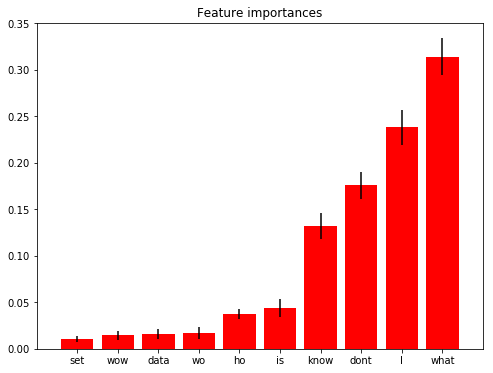

In [34]:
#Feature Importance
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[:]
# Plot the feature importances of the forest
plt.figure()
fig,ax1=plt.subplots(figsize=(8,6))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), df.columns.values[indices])
plt.xlim([-1, X.shape[1]])
plt.show()

In [35]:
importance_itf_columns=pd.DataFrame(importances,index=X_train.columns,columns=['importance'])\
                        .sort_values(by='importance',ascending=False)
print(importance_itf_columns)

      importance
what    0.314166
I       0.238081
dont    0.175644
know    0.132493
is      0.044116
ho      0.037092
wo      0.017219
data    0.015955
wow     0.014584
set     0.010651


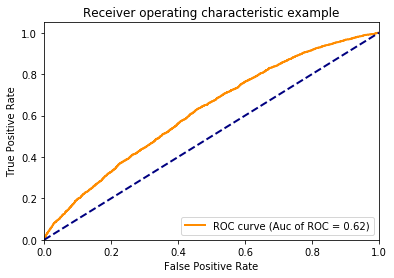

In [40]:
#ROC,AUC of ROC
n_classes = len(y_test)
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr[1], tpr[1], _ = metrics.roc_curve(y_test, pred_proba[:,1])
roc_auc[1] = metrics.auc(fpr[1], tpr[1])

# Compute micro-average ROC curve and ROC area
#fpr[1], tpr[1], _ = metrics.roc_curve(y_test.ravel(), pred_test.ravel())

#roc_auc[1] = metrics.auc(fpr[1], tpr[1])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (Auc of ROC = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Confusion matrix, without normalization
[[2042 1968]
 [1350 2612]]
Normalized confusion matrix
[[ 0.5092  0.4908]
 [ 0.3407  0.6593]]


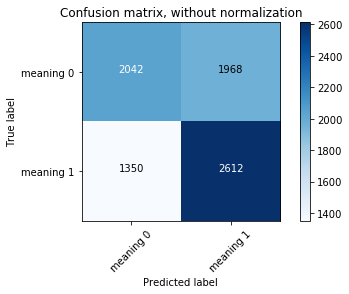

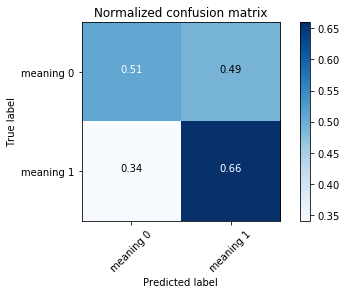

In [45]:
#Cofusion Matrix 混淆矩阵

#define a function to plot confusion matrix. 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max()-cm.min()) / 2.0+cm.min()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred_test)
np.set_printoptions(precision=4)

#在这里定义你y的两类都代表什么意义，第一个item是y=0，第二个是y=1
class_names = np.array(['meaning 0', 'meaning 1'])
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### If you'd like to try XGB  ; )

In [ ]:
xg = XGBClassifier(max_depth = 5)
xg.fit(X_train, y_train)
xg.score(X_test, y_test)